<a href="https://colab.research.google.com/github/Fathmat/MultiClass_classification/blob/master/Bert_sequence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install transformers datasets

In [9]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [10]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
ROOT_DIR = "/content/extracted_data.csv"

df_org= pd.read_csv(ROOT_DIR)

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,Unnamed: 0,category,text
529,2016-02-26_2016-02-26_1175,DOCUMENT UPDATE,# Item 5.03 Amendments to Articles of Incorpor...
342,2023-05-08_2023-05-08_609,OPERATION ACTIVITIES,# Item 5.07 Submission of Matters to a Vote of...
352,2020-02-24_2020-02-24_864,FINANCIAL ACTIVITIES,# Item 2.02 RESULTS OF OPERATIONS AND FINANCIA...
819,2021-09-22_2021-09-22_1065,INFORMATION DISCLOSURE,# Item 2.02 Results of Operations and Financia...
277,2010-06-10_2010-06-10_1778,FINANCIAL ACTIVITIES,# Item 1.01 Entry into a Material Definitive A...


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['DOCUMENT UPDATE',
 'OPERATION ACTIVITIES',
 'FINANCIAL ACTIVITIES',
 'INFORMATION DISCLOSURE',
 'BUSINESS COMBINATION AND RESTRUCTURING',
 'SENIOR PERSONNEL CHANGE',
 'SHARE BUYBACK/REPURCHASE PROGRAM BEGIN',
 'BUSINESS COMBINATION AND RESTRUCTURING',
 'NONE',
 'SHARE BUYBACK/REPURCHASE PROGRAM UPDATE',
 'LITIGATION AND LAWSUIT']

In [14]:
for key, value in enumerate(labels):
    print(value)

DOCUMENT UPDATE
OPERATION ACTIVITIES
FINANCIAL ACTIVITIES
INFORMATION DISCLOSURE
BUSINESS COMBINATION AND RESTRUCTURING
SENIOR PERSONNEL CHANGE
SHARE BUYBACK/REPURCHASE PROGRAM BEGIN
BUSINESS COMBINATION AND RESTRUCTURING
NONE
SHARE BUYBACK/REPURCHASE PROGRAM UPDATE
LITIGATION AND LAWSUIT


In [15]:
for key, value in enumerate(labels):
    print(value)

DOCUMENT UPDATE
OPERATION ACTIVITIES
FINANCIAL ACTIVITIES
INFORMATION DISCLOSURE
BUSINESS COMBINATION AND RESTRUCTURING
SENIOR PERSONNEL CHANGE
SHARE BUYBACK/REPURCHASE PROGRAM BEGIN
BUSINESS COMBINATION AND RESTRUCTURING
NONE
SHARE BUYBACK/REPURCHASE PROGRAM UPDATE
LITIGATION AND LAWSUIT


In [16]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [17]:
id2label, label2id

({0: 'DOCUMENT UPDATE',
  1: 'OPERATION ACTIVITIES',
  2: 'FINANCIAL ACTIVITIES',
  3: 'INFORMATION DISCLOSURE',
  4: 'BUSINESS COMBINATION AND RESTRUCTURING',
  5: 'SENIOR PERSONNEL CHANGE',
  6: 'SHARE BUYBACK/REPURCHASE PROGRAM BEGIN',
  7: 'BUSINESS COMBINATION AND RESTRUCTURING',
  8: 'NONE',
  9: 'SHARE BUYBACK/REPURCHASE PROGRAM UPDATE',
  10: 'LITIGATION AND LAWSUIT'},
 {'DOCUMENT UPDATE': 0,
  'OPERATION ACTIVITIES': 1,
  'FINANCIAL ACTIVITIES': 2,
  'INFORMATION DISCLOSURE': 3,
  'BUSINESS COMBINATION AND RESTRUCTURING': 7,
  'SENIOR PERSONNEL CHANGE': 5,
  'SHARE BUYBACK/REPURCHASE PROGRAM BEGIN': 6,
  'NONE': 8,
  'SHARE BUYBACK/REPURCHASE PROGRAM UPDATE': 9,
  'LITIGATION AND LAWSUIT': 10})

In [18]:
df_org.head()

,Unnamed: 0,category,text
529,2016-02-26_2016-02-26_1175,DOCUMENT UPDATE,# Item 5.03 Amendments to Articles of Incorpor...
342,2023-05-08_2023-05-08_609,OPERATION ACTIVITIES,# Item 5.07 Submission of Matters to a Vote of...
352,2020-02-24_2020-02-24_864,FINANCIAL ACTIVITIES,# Item 2.02 RESULTS OF OPERATIONS AND FINANCIA...
819,2021-09-22_2021-09-22_1065,INFORMATION DISCLOSURE,# Item 2.02 Results of Operations and Financia...
277,2010-06-10_2010-06-10_1778,FINANCIAL ACTIVITIES,# Item 1.01 Entry into a Material Definitive A...


In [19]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [20]:
df_org.head()

,Unnamed: 0,category,text,labels
529,2016-02-26_2016-02-26_1175,DOCUMENT UPDATE,# Item 5.03 Amendments to Articles of Incorpor...,0
342,2023-05-08_2023-05-08_609,OPERATION ACTIVITIES,# Item 5.07 Submission of Matters to a Vote of...,1
352,2020-02-24_2020-02-24_864,FINANCIAL ACTIVITIES,# Item 2.02 RESULTS OF OPERATIONS AND FINANCIA...,2
819,2021-09-22_2021-09-22_1065,INFORMATION DISCLOSURE,# Item 2.02 Results of Operations and Financia...,3
277,2010-06-10_2010-06-10_1778,FINANCIAL ACTIVITIES,# Item 1.01 Entry into a Material Definitive A...,2


<Axes: ylabel='count'>

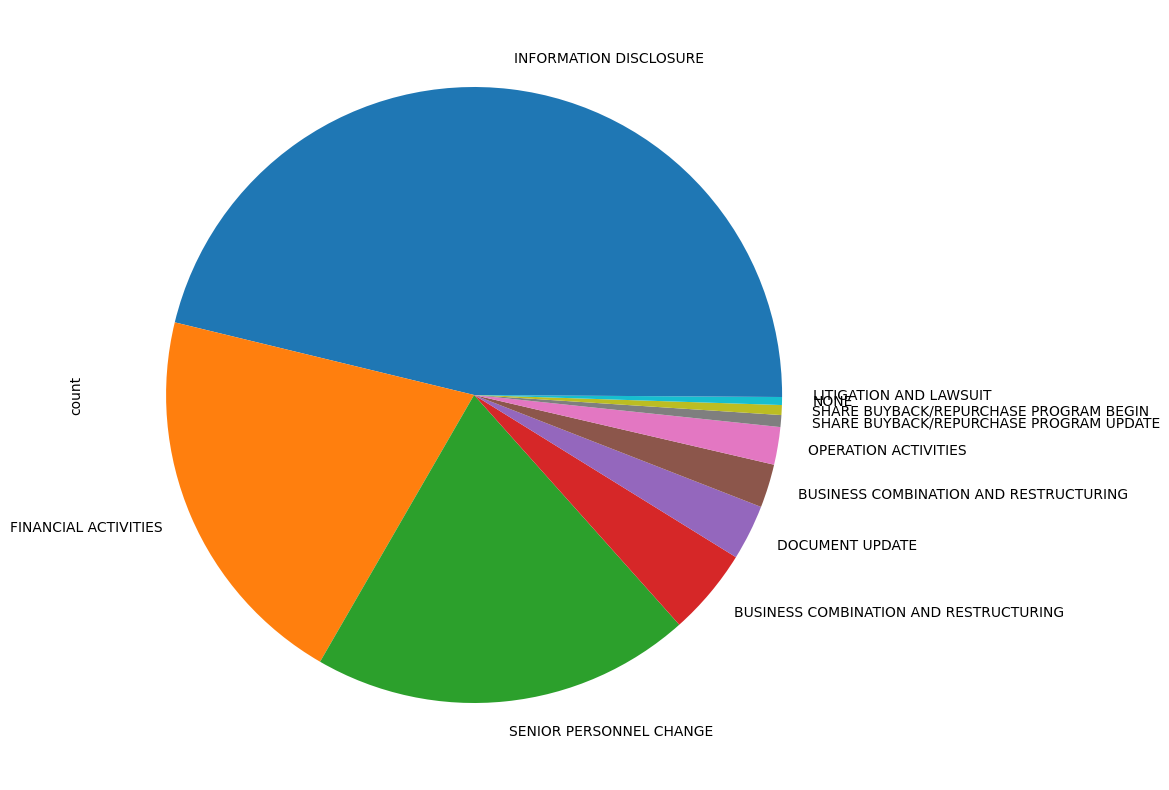

In [21]:
df_org.category.value_counts().plot(kind='pie', figsize=(10,10))

In [22]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
SIZE= df_org.shape[0]

train_texts= list(df_org.text[:SIZE//2])

val_texts=   list(df_org.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [25]:
len(train_texts)

481

In [26]:
len(train_texts), len(val_texts), len(test_texts)

(481, 241, 241)

In [27]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [28]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings= encodings
        self.labels= labels
    def __getitem__(self,idx):
        item= {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels']=torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [29]:
train_dataloader = DataLoader(train_encodings,train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataloader = DataLoader(test_encodings, test_labels)

In [30]:
from transformers import TrainingArguments, Trainer

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(pred):
   labels = pred.label_ids
   preds =  pred.predictions.argmax(-1)
   precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'macro')
   acc= accuracy_score(labels, preds)

   return{
      'Acurracy':acc,
      'F1' : f1,
      'Precision': precision,
      'Recall': recall

   }

In [32]:
training_args= TrainingArguments(
    output_dir='./Bert_finetuned_Test',
    do_train= True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size= 32,
    warmup_steps=100,
    weight_decay= 0.01,
    logging_strategy= 'steps',
    logging_dir= './multi-calss-logs',
    logging_steps=50,
    evaluation_strategy= "steps",
    eval_steps=50,
    save_strategy="steps",
    fp16= True,
    load_best_model_at_end= True

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [34]:
trainer.train()

Step,Training Loss,Validation Loss,Acurracy,F1,Precision,Recall
50,2.145300,1.257162,0.680498,0.263579,0.303146,0.275950


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=93, training_loss=1.7160223684003275, metrics={'train_runtime': 48.584, 'train_samples_per_second': 29.701, 'train_steps_per_second': 1.914, 'total_flos': 379699932957696.0, 'train_loss': 1.7160223684003275, 'epoch': 3.0})

In [35]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Acurracy,eval_F1,eval_Precision,eval_Recall
train,0.876862,0.777547,0.286940,0.381875,0.301155
val,0.821467,0.788382,0.358807,0.351788,0.369803
test,0.843404,0.780083,0.273731,0.269841,0.283557


In [36]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [37]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True,  return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [38]:
text = "Item 2.02 Results of Operations and Financial Condition On April 24, 2012, Waters Corporation announced its results of operations for the quarter ended March 31, 2012. A copy of the related press release is attached hereto as Exhibit 99.1 to this Form 8-K and is incorporated herein by reference in its entirety. 9.01 Financial Statements and Exhibits"
predict(text)

(tensor([[0.0330, 0.0375, 0.1946, 0.4587, 0.0117, 0.1485, 0.0160, 0.0669, 0.0147,
          0.0094, 0.0088]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(3, device='cuda:0'),
 'INFORMATION DISCLOSURE')

In [39]:
model_path = "TEST"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('TEST/tokenizer_config.json',
 'TEST/special_tokens_map.json',
 'TEST/vocab.txt',
 'TEST/added_tokens.json',
 'TEST/tokenizer.json')

In [52]:
#reload the model for inference
model_path = "TEST"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, function_to_apply= 'none', max_length=512, truncation= True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [54]:
nlp("# Item 8.01 Other Events   On March 7, 2012, Kimberly-Clark Corporation announced that Tony Palmer has been elected as President, Global Brands and Innovation. Mr. Palmers former position was Senior Vice President and Chief Marketing Officer. A copy of the news release announcing the election is attached as Exhibit 99.1 hereto.   ---  # Item 9.01 Financial Statements and Exhibits   (d) Exhibits99.1 News release issued by Kimberly-Clark Corporation on March 7, 2012.   EXHIBIT INDEX")

[{'label': 'SENIOR PERSONNEL CHANGE', 'score': 2.75545072555542}]

In [55]:
# Function to truncate text to a maximum length
def truncate_text(text, max_length):
  tokens = tokenizer.encode(text, truncation=True, max_length=max_length)
  return tokenizer.decode(tokens)

In [80]:
dataTest= pd.read_csv("/content/DataToBeCategorize.csv")
dataTest.head()

,CIK,ID,Report Date,Item Numbers,Company,Filling date F,Published date F,Counter,Unnamed: 8
0,55785,2012-03-07_2012-03-07_1464,2012-03-07,"# Item 8.01 Other Events On March 7, 2012, K...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2012-03-07,2012-03-07,1464,NaN
1,55785,2015-02-27_2015-02-27_1245,2015-02-27,"# Item 8.01 Other Events. On February 24, 20...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2015-02-27,2015-02-27,1245,NaN
2,55785,2017-09-07_2017-09-07_1059,2017-09-07,"# Item 8.01 Other Events. On August 31, 2017...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2017-09-07,2017-09-07,1059,NaN
3,55785,2011-10-24_2011-10-24_376,2011-10-24,# Item 2.02Results of Operations and Financial...,KIMBERLY-CLARK CORPORATION COMMON STOCK,2011-10-24,2011-10-24,376,NaN
4,55785,2023-04-20_2023-04-20_160,2023-04-20,# Item 5.07 Submission of Matters to a Vote of...,KIMBERLY-CLARK CORPORATION COMMON STOCK,2023-04-20,2023-04-20,160,NaN


In [57]:
dataTest['categories'] = nlp([truncate_text(text, 512) for text in dataTest['Item Numbers'].tolist()])

In [58]:
dataTest.head()

,CIK,ID,Report Date,Item Numbers,Company,Filling date F,Published date F,Counter,Unnamed: 8,categories
0,55785,2012-03-07_2012-03-07_1464,2012-03-07,"# Item 8.01 Other Events On March 7, 2012, K...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2012-03-07,2012-03-07,1464,NaN,"{'label': 'SENIOR PERSONNEL CHANGE', 'score': ..."
1,55785,2015-02-27_2015-02-27_1245,2015-02-27,"# Item 8.01 Other Events. On February 24, 20...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2015-02-27,2015-02-27,1245,NaN,"{'label': 'INFORMATION DISCLOSURE', 'score': 3..."
2,55785,2017-09-07_2017-09-07_1059,2017-09-07,"# Item 8.01 Other Events. On August 31, 2017...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2017-09-07,2017-09-07,1059,NaN,"{'label': 'INFORMATION DISCLOSURE', 'score': 3..."
3,55785,2011-10-24_2011-10-24_376,2011-10-24,# Item 2.02Results of Operations and Financial...,KIMBERLY-CLARK CORPORATION COMMON STOCK,2011-10-24,2011-10-24,376,NaN,"{'label': 'INFORMATION DISCLOSURE', 'score': 3..."
4,55785,2023-04-20_2023-04-20_160,2023-04-20,# Item 5.07 Submission of Matters to a Vote of...,KIMBERLY-CLARK CORPORATION COMMON STOCK,2023-04-20,2023-04-20,160,NaN,"{'label': 'INFORMATION DISCLOSURE', 'score': 2..."


In [75]:
dataTest['category']= dataTest['categories'].str.get('label')
dataTest.head()

,CIK,ID,Report Date,Item Numbers,Company,Filling date F,Published date F,Counter,Unnamed: 8,categories,"(categoriesL, categoriesS)",category
0,55785,2012-03-07_2012-03-07_1464,2012-03-07,"# Item 8.01 Other Events On March 7, 2012, K...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2012-03-07,2012-03-07,1464,NaN,"{'label': 'SENIOR PERSONNEL CHANGE', 'score': ...",NaN,SENIOR PERSONNEL CHANGE
1,55785,2015-02-27_2015-02-27_1245,2015-02-27,"# Item 8.01 Other Events. On February 24, 20...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2015-02-27,2015-02-27,1245,NaN,"{'label': 'INFORMATION DISCLOSURE', 'score': 3...",NaN,INFORMATION DISCLOSURE
2,55785,2017-09-07_2017-09-07_1059,2017-09-07,"# Item 8.01 Other Events. On August 31, 2017...",KIMBERLY-CLARK CORPORATION COMMON STOCK,2017-09-07,2017-09-07,1059,NaN,"{'label': 'INFORMATION DISCLOSURE', 'score': 3...",NaN,INFORMATION DISCLOSURE
3,55785,2011-10-24_2011-10-24_376,2011-10-24,# Item 2.02Results of Operations and Financial...,KIMBERLY-CLARK CORPORATION COMMON STOCK,2011-10-24,2011-10-24,376,NaN,"{'label': 'INFORMATION DISCLOSURE', 'score': 3...",NaN,INFORMATION DISCLOSURE
4,55785,2023-04-20_2023-04-20_160,2023-04-20,# Item 5.07 Submission of Matters to a Vote of...,KIMBERLY-CLARK CORPORATION COMMON STOCK,2023-04-20,2023-04-20,160,NaN,"{'label': 'INFORMATION DISCLOSURE', 'score': 2...",NaN,INFORMATION DISCLOSURE


In [79]:
dataTest.to_csv("dataTest.csv")
